In [44]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import copy
import cv2
import keras
from string import printable
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, MaxPooling1D, UpSampling2D, Flatten, LSTM, SimpleRNN, Embedding, Lambda, GlobalMaxPooling1D, BatchNormalization, ELU
from keras.models import Model, Sequential
from keras.datasets import fashion_mnist
from keras import backend
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from PIL import Image
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import RMSprop
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras.callbacks import TensorBoard
from keras.preprocessing.sequence import pad_sequences

In [15]:
#3.1

In [153]:
benign_list = []
malicious_list = []

with open("benign-urls.txt") as files:
    lines = files.readlines()
    for line in lines:
        if not line.startswith("#"):
            line = line.strip()
            benign_list.append(line)

with open("malicious-urls.txt") as files:
    lines = files.readlines()
    for line in lines:
        line = line.strip()
        malicious_list.append(line)

In [154]:
total = benign_list + malicious_list
y = np.concatenate([np.ones(len(benign_list)), np.zeros(len(malicious_list))])
df = pd.DataFrame({'urls': total, 'label': y})
max_len = 0
total_url_token = []

for url in df.urls:
    sub_url_token = []
    for link in url:
        sub_url_token.append(printable.index(link))
    total_url_token.append(sub_url_token)
    max_len = max(max_len, len(sub_url_token))

input_X = pad_sequences(total_url_token, maxlen=max_len)
input_y = np.array(df.label)
X_train, X_test, y_train, y_test = train_test_split(input_X, input_y, test_size=0.2, shuffle=True, random_state = 1240)

In [155]:
model_rnn = Sequential()
model_rnn.add(Embedding(90, 32))
model_rnn.add(LSTM(64))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(1, activation ='sigmoid'))
model_rnn.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics=['acc'])
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, None, 32)          2880      
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_125 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 65        
Total params: 27,777
Trainable params: 27,777
Non-trainable params: 0
_________________________________________________________________


In [156]:
model_rnn.fit(X_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
53848/53848 [==============================] - 38s 709us/step - loss: 0.0803 - acc: 0.9792
Epoch 2/10
53848/53848 [==============================] - 35s 652us/step - loss: 0.0322 - acc: 0.9837
Epoch 3/10
53848/53848 [==============================] - 36s 661us/step - loss: 0.0257 - acc: 0.9872
Epoch 4/10
53848/53848 [==============================] - 35s 657us/step - loss: 0.0246 - acc: 0.9888
Epoch 5/10
53848/53848 [==============================] - 35s 657us/step - loss: 0.0237 - acc: 0.9888
Epoch 6/10
53848/53848 [==============================] - 36s 670us/step - loss: 0.0230 - acc: 0.9893
Epoch 7/10
53848/53848 [==============================] - 37s 686us/step - loss: 0.0226 - acc: 0.9894
Epoch 8/10
53848/53848 [==============================] - 36s 670us/step - loss: 0.0219 - acc: 0.9891
Epoch 9/10
53848/53848 [==============================] - 40s 744us/step - loss: 0.0212 - acc: 0.9899
Epoch 10/10
53848/53848 [==============================] - 37s 696us/step - loss: 

In [157]:
print("Train classification accuracy rate %0.05f" % model_rnn.evaluate(X_train, y_train, verbose=0)[1])
print("Test classification accuracy rate %0.05f" % model_rnn.evaluate(X_test, y_test, verbose=0)[1])

Train classification accuracy rate 0.99042
Test classification accuracy rate 0.98849


In [ ]:
#3.2

In [158]:
benign_list = []
malicious_list = []

with open("benign-urls.txt") as files:
    lines = files.readlines()
    for line in lines:
        if not line.startswith("#"):
            line = line.strip()
            benign_list.append(line)

with open("malicious-urls.txt") as files:
    lines = files.readlines()
    for line in lines:
        line = line.strip()
        malicious_list.append(line)

In [159]:
total = benign_list + malicious_list
y = np.concatenate([np.ones(len(benign_list)), np.zeros(len(malicious_list))])
df = pd.DataFrame({'urls': total, 'label': y})
max_len = 0
total_url_token = []

for url in df.urls:
    sub_url_token = []
    for link in url:
        sub_url_token.append(printable.index(link))
    total_url_token.append(sub_url_token)
    max_len = max(max_len, len(sub_url_token))

input_X = pad_sequences(total_url_token, maxlen=max_len)
input_y = np.array(df.label)
x_train, x_test, y_train, y_test = train_test_split(input_X, input_y, test_size=0.2, shuffle=True, random_state = 1240)

In [160]:
def totalsum(X):
    return backend.sum(X, axis=1)

In [161]:
model_cnn = Sequential()
model_cnn.add(Embedding(90, 32, input_length=max_len))
model_cnn.add(Dropout(0.3))
model_cnn.add(Conv1D(filters=256, kernel_size=2, activation='relu', padding='same'))
model_cnn.add(Lambda(totalsum, output_shape=(256,)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(256, activation='sigmoid'))
model_cnn.add(BatchNormalization(mode=0))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_58 (Embedding)     (None, 86, 32)            2880      
_________________________________________________________________
dropout_126 (Dropout)        (None, 86, 32)            0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 86, 256)           16640     
_________________________________________________________________
lambda_41 (Lambda)           (None, 256)               0         
_________________________________________________________________
dropout_127 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_36 (Batc (None, 256)               1024      
__________

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization()`
  


In [162]:
model_cnn.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1)

Epoch 1/10
53848/53848 [==============================] - 18s 339us/step - loss: 0.1625 - acc: 0.9397
Epoch 2/10
53848/53848 [==============================] - 15s 284us/step - loss: 0.0582 - acc: 0.9796
Epoch 3/10
53848/53848 [==============================] - 15s 280us/step - loss: 0.0503 - acc: 0.9824
Epoch 4/10
53848/53848 [==============================] - 15s 282us/step - loss: 0.0451 - acc: 0.9836
Epoch 5/10
53848/53848 [==============================] - 15s 282us/step - loss: 0.0415 - acc: 0.9845
Epoch 6/10
53848/53848 [==============================] - 15s 282us/step - loss: 0.0412 - acc: 0.9848
Epoch 7/10
53848/53848 [==============================] - 15s 285us/step - loss: 0.0388 - acc: 0.9854
Epoch 8/10
53848/53848 [==============================] - 15s 282us/step - loss: 0.0388 - acc: 0.9853
Epoch 9/10
53848/53848 [==============================] - 16s 288us/step - loss: 0.0374 - acc: 0.9851
Epoch 10/10
53848/53848 [==============================] - 17s 323us/step - loss: 

In [163]:
print("Train classification accuracy rate %0.05f" % model_cnn.evaluate(X_train, y_train, verbose=0)[1])
print("Test classification accuracy rate %0.05f" % model_cnn.evaluate(X_test, y_test, verbose=0)[1])

Train classification accuracy rate 0.98137
Test classification accuracy rate 0.98128


3.3

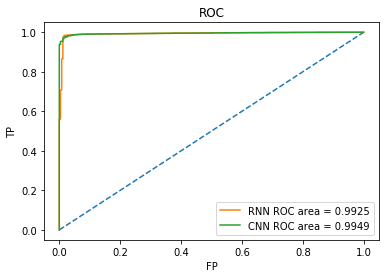

In [164]:
rnn_result = model_rnn.predict(X_test)
(rnn_fp, rnn_tp, rnn_threshold) = roc_curve(y_test, rnn_result)
rnn_auc = auc(rnn_fp, rnn_tp)

cnn_result = model_cnn.predict(X_test)
(cnn_fp, cnn_tp, cnn_threshold) = roc_curve(y_test, cnn_result)
cnn_auc = auc(cnn_fp, cnn_tp)

plt.figure()
plt.title('ROC')
plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1], [0, 1], linestyle='dashed')
plt.plot(rnn_fp, rnn_tp, label='RNN ROC area = %0.4f' % rnn_auc)
plt.plot(cnn_fp, cnn_tp, label='CNN ROC area = %0.4f' % cnn_auc)
plt.legend(loc="best")
plt.show()